# WS23/24: Image Processing and Computational  Photography

------

## Lab 10 : From Paired to Unpaired Image-to-Image Translation 

#### Instructors: Georgy Perevozchikov (PhD), Prof. Dr. Radu Timofte

<br>
<br>

# Image2Image (I2I) Translation

## Content
- Paired I2I
  - DPED
  - MW-ISP Net
- Unpaired I2I
  - Cycle GAN
  - WESPE
  - UVCGAN v2

# DPED

In [48]:
import os
os.chdir('networks/dped/')

In [44]:
import numpy as np
import tensorflow as tf
import os
import scipy.misc
from easydict import EasyDict as edict
from DPED import *
from utils import *
from ops import *

%reload_ext autoreload
%autoreload 2

config = edict()
# training parameters
config.batch_size = 50
config.patch_size = 100
config.mode = "RGB" #YCbCr
config.channels = 3
config.content_layer = 'relu5_4'
config.learning_rate = 1e-4
config.augmentation = True #data augmentation (flip, rotation)

# weights for loss
config.w_color = 1.2 # gaussian blur + mse (originally 0.1)
config.w_texture = 1 # gan (originally 0.4)
config.w_content = 2 # vgg19 (originally 1)
config.w_tv = 1/400 # total variation (originally 400)

# directories
config.dataset_name = "iphone"
config.train_path_phone = os.path.join("./dped",str(config.dataset_name),"training_data",str(config.dataset_name),"*.jpg")
config.train_path_dslr = os.path.join("./dped",str(config.dataset_name),"training_data/canon/*.jpg")
config.test_path_phone_patch = os.path.join("./dped",str(config.dataset_name),"test_data/patches",str(config.dataset_name),"*.jpg")
config.test_path_dslr_patch = os.path.join("./dped",str(config.dataset_name),"test_data/patches/canon/*.jpg")
config.test_path_phone_image = os.path.join("./dped/sample_images/original_images",str(config.dataset_name),"*.jpg")
config.test_path_dslr_image = os.path.join("./dped/sample_images/original_images/canon/*.jpg")
config.sample_dir = "samples"
config.checkpoint_dir = "checkpoint"
config.vgg_dir = "./vgg_pretrained/imagenet-vgg-verydeep-19.mat"
config.log_dir = "logs"

if not os.path.exists(config.checkpoint_dir):
    os.makedirs(config.checkpoint_dir)
if not os.path.exists(config.sample_dir):
    os.makedirs(config.sample_dir)
if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# load dataset
dataset_phone, dataset_dslr = load_dataset(config)

In [ ]:
# build DPED model
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
model = DPED(sess, config, dataset_phone, dataset_dslr)

In [ ]:
model.test_generator(100, 14, load = True)

In [ ]:
# pretrain discriminator with (phone, dslr) pairs
model.pretrain_discriminator(load = False, epoch = 1)
# train generator & discriminator together
model.train(load = True, epoch = 1)
model.save()

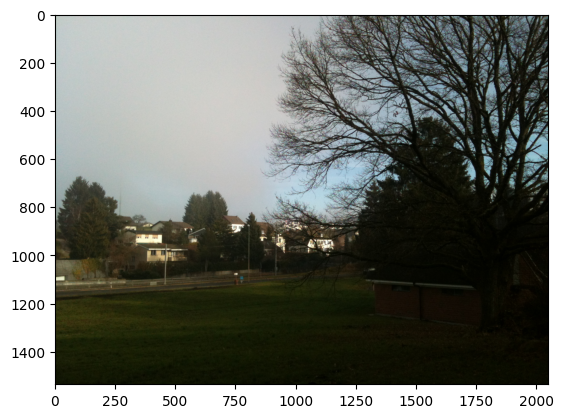

In [49]:
import matplotlib.pyplot as plt

img = plt.imread('./samples/iphone/image/phone_0.png')
plt.imshow(img)

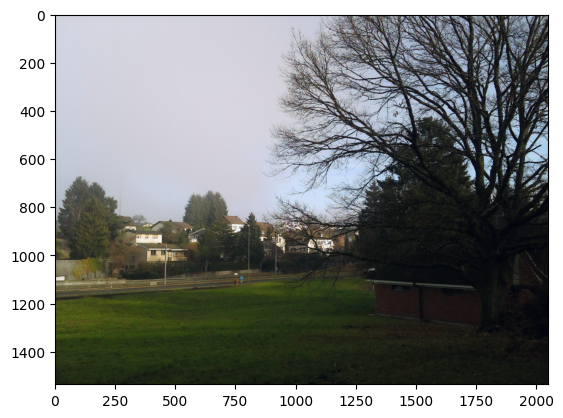

In [50]:
img = plt.imread('./samples/iphone/image/enhanced_0.png')
plt.imshow(img)

# MW-ISP Net

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
import torch
import matplotlib.pyplot as plt
import random
from networks.mw_isp.core.mssim import MSSSIM
from networks.mw_isp.core.load_data import LoadTrainData
from networks.mw_isp.core.mwcnn_model import MWRCAN, Discriminator
from networks.mw_isp.core.vgg import vgg_19
from networks.mw_isp.core.utils import normalize_batch, BaseOptions
import os
from tqdm import tqdm
import math

In [2]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

0.png | 0.png
1.png | 1.png
10.png | 10.png
11.png | 11.png
12.png | 12.png
13.png | 13.png
14.png | 14.png
15.png | 15.png
16.png | 16.png
17.png | 17.png
Number of samples: 43
Number train batches: 43
Number val batches: 43


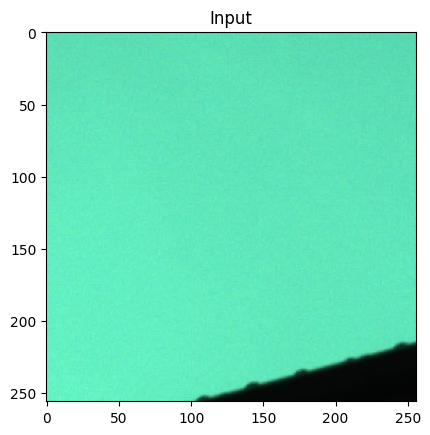

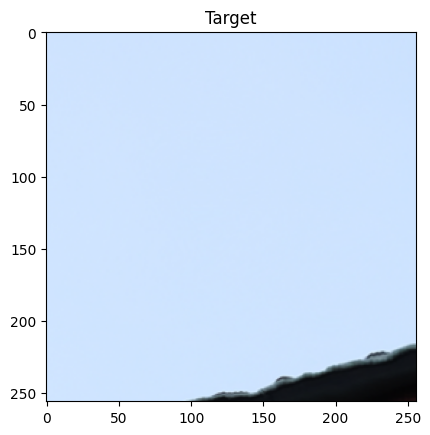

In [3]:
from networks.mw_isp.core.load_data import LoadTrainData

base_dir = "datasets/mai21/test"
train_input_dir = os.path.join(base_dir, "raw")
train_target_dir = os.path.join(base_dir, "rgb")
img_size = (126, 126)
input_channels = 3
output_channels = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
val_input_img_paths = input_img_paths
val_target_img_paths = target_img_paths

train_dataset = LoadTrainData(val_input_img_paths, val_input_img_paths)
test_dataset = LoadTrainData(val_input_img_paths, val_target_img_paths, test=True)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_dataset))
print("Number val batches:", len(test_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=12,
                              pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=1,
                            pin_memory=True, drop_last=True)

batch = next(iter(val_loader))
batch_input, batch_target = batch
input_inage = batch_input[0].permute(1, 2, 0).numpy()
target_image = batch_target[0].permute(1, 2, 0).numpy()
plt_display(input_inage, "Input")
plt_display(target_image, "Target")

In [6]:
device = torch.device("cuda")
generator = MWRCAN().to(device)
generator = torch.nn.DataParallel(generator)
optimizer = Adam(params=generator.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50,100,150,200], gamma=0.5)
VGG_19 = vgg_19(device)
MSE_loss = torch.nn.MSELoss()
MS_SSIM = MSSSIM()
L1_loss = torch.nn.L1Loss()
number_of_epochs = 10


for epoch in range(number_of_epochs):
    print("lr =  %.8f" % (scheduler.get_lr()[0]))
    torch.cuda.empty_cache()
    generator.to(device).train()
    n_samples = len(train_loader)
    with tqdm(total=n_samples, desc=f'Epoch {epoch + 1}/{300}', unit='batch') as pbar:
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            enhanced = generator(x)

            loss_l1 = L1_loss(enhanced, y)

            enhanced_vgg = VGG_19(normalize_batch(enhanced))
            target_vgg = VGG_19(normalize_batch(y))
            loss_content = L1_loss(enhanced_vgg, target_vgg)

            loss_ssim = MS_SSIM(enhanced, y)

            total_loss = loss_l1 + loss_content + (1 - loss_ssim) * 0.15
            
            pbar.update(1)
            pbar.set_postfix(**{
                'l1': '%.4f' % loss_l1,
                'vgg': '%.4f' % loss_content,
                'total': '%.4f' % total_loss,
            })

            total_loss.backward()
            optimizer.step()
        scheduler.step()   

    # Save the model that corresponds to the current epoch
    torch.save(generator.state_dict(), os.path.join('networks/mw_isp', "mwrcan_epoch_" + str(epoch) + ".pth"))      

    # Evaluate the model
    loss_psnr_eval = 0
    generator.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            enhanced = generator(x)
            enhanced = torch.clamp(torch.round(enhanced*255), min=0, max=255) / 255
            y = torch.clamp(torch.round(y*255), min=0, max=255) / 255
            loss_mse_temp = MSE_loss(enhanced, y).item()
            loss_psnr_eval += 20 * math.log10(1.0 / math.sqrt(loss_mse_temp))
    loss_psnr_eval = loss_psnr_eval / len(test_dataset)            
    print("Epoch %d, psnr: %.4f" % (epoch, loss_psnr_eval))

lr =  0.00010000


Epoch 1/300: 100%|██████████| 2/2 [00:01<00:00,  1.86batch/s, l1=0.1615, total=0.3409, vgg=0.0799]


Epoch 0, psnr: 9.7539
lr =  0.00010000


Epoch 2/300: 100%|██████████| 2/2 [00:01<00:00,  1.88batch/s, l1=0.1473, total=0.3189, vgg=0.0843]


Epoch 1, psnr: 9.8344
lr =  0.00010000


Epoch 3/300: 100%|██████████| 2/2 [00:01<00:00,  1.89batch/s, l1=0.1590, total=0.3264, vgg=0.0826]


Epoch 2, psnr: 9.9533
lr =  0.00010000


Epoch 4/300: 100%|██████████| 2/2 [00:01<00:00,  1.88batch/s, l1=0.1424, total=0.3002, vgg=0.0759]


Epoch 3, psnr: 10.1424
lr =  0.00010000


Epoch 5/300: 100%|██████████| 2/2 [00:01<00:00,  1.88batch/s, l1=0.1704, total=0.3400, vgg=0.0865]


Epoch 4, psnr: 10.3709
lr =  0.00010000


Epoch 6/300: 100%|██████████| 2/2 [00:01<00:00,  1.89batch/s, l1=0.1712, total=0.3471, vgg=0.0856]


Epoch 5, psnr: 10.5262
lr =  0.00010000


Epoch 7/300: 100%|██████████| 2/2 [00:01<00:00,  1.88batch/s, l1=0.1339, total=0.3054, vgg=0.0792]


Epoch 6, psnr: 10.6506
lr =  0.00010000


Epoch 8/300: 100%|██████████| 2/2 [00:01<00:00,  1.88batch/s, l1=0.1194, total=0.2817, vgg=0.0770]


Epoch 7, psnr: 10.7377
lr =  0.00010000


Epoch 9/300: 100%|██████████| 2/2 [00:01<00:00,  1.75batch/s, l1=0.1309, total=0.2969, vgg=0.0844]


Epoch 8, psnr: 10.8041
lr =  0.00010000


Epoch 10/300: 100%|██████████| 2/2 [00:01<00:00,  1.89batch/s, l1=0.1243, total=0.2846, vgg=0.0802]


Epoch 9, psnr: 10.8105


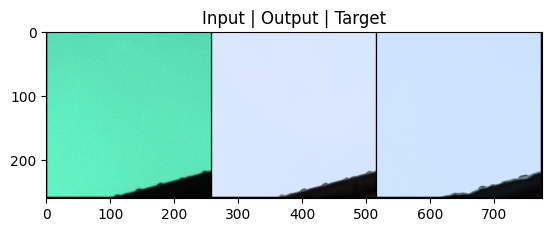

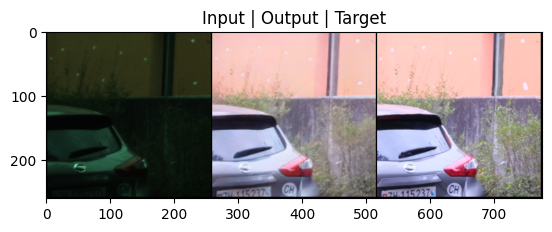

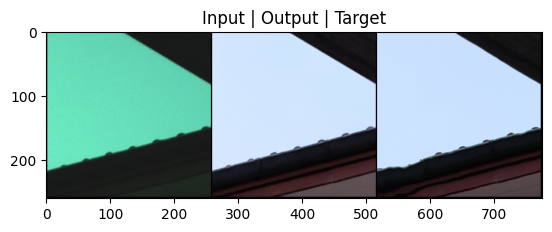

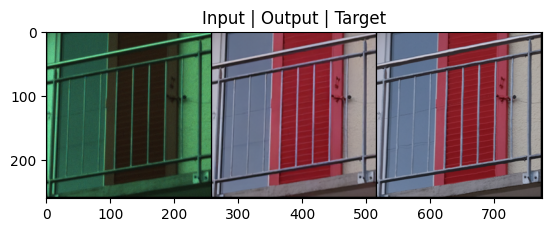

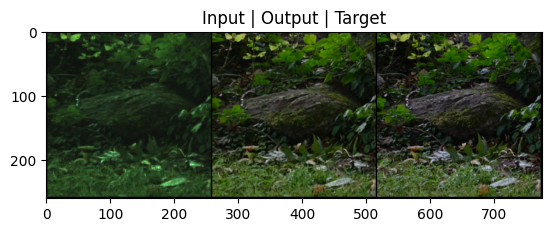

In [24]:
from torchvision.utils import make_grid

model_pth = 'networks/mw_isp/mwrcan.pth'
device = torch.device("cuda")
model = MWRCAN().to(device)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_pth), strict=True)
model.eval()
n = 0
max_n = 5

for x, y in val_loader:
    if n == max_n:
        break
    n += 1
    
    enhanced = model(x)
    enhanced = torch.clamp(torch.round(enhanced*255), min=0, max=255) / 255
    y = torch.clamp(torch.round(y*255), min=0, max=255) / 255
    grig = make_grid([x[0].cpu(), enhanced[0].cpu(), y[0].cpu()], nrow=3)
    grig = grig.permute(1, 2, 0).cpu().detach().numpy()
    plt_display(grig, "Input | Output | Target")

# Cycle GAN

In [10]:
import os
os.chdir('networks/cycle_gan_pix2pix/')

In [14]:
!pip install -r requirements.txt

  Obtaining dependency information for dominate>=2.4.0 from https://files.pythonhosted.org/packages/58/19/0380af745f151a1648657bbcef0fb49ac28bf09083d94498163ffd9b32dc/dominate-2.9.1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for jsonpatch from https://files.pythonhosted.org/packages/73/07/02e16ed01e04a374e644b575638ec7987ae846d25ad97bcc9945a3ee4b0e/jsonpatch-1.33-py2.py3-none-any.whl.metadata
  Obtaining dependency information for jsonpointer>=1.9 from https://files.pythonhosted.org/packages/12/f6/0232cc0c617e195f06f810534d00b74d2f348fe71b2118009ad8ad31f878/jsonpointer-2.4-py2.py3-none-any.whl.metadata
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408197 sha256=cfe844f088507bb8981c8f550acd2f6c7a852249ae0dd8e5edf5c4f4a6c141d3
  Stored in directory: /home/gosha20777/.cache/pip/wheels/58/9e/14/30f7cc4dafdd

In [11]:
!bash ./datasets/download_cyclegan_dataset.sh horse2zebra

Specified [horse2zebra]
for details.

--2024-02-05 11:15:28--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111,45M  4,14MB/s    in 92s     

2024-02-05 11:17:02 (1,22 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/t

In [12]:
!bash ./scripts/download_cyclegan_model.sh horse2zebra

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [horse2zebra]
for details.

--2024-02-05 11:18:23--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/horse2zebra.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/horse2zebra_pretrained/latest_net_G.pth’

./checkpoints/horse 100%[===================>]  43,46M  8,28MB/s    in 8,0s    

2024-02-05 11:18:31 (5,45 MB/s) - ‘./checkpoints/horse2zebra_pretrained/latest_net_G.pth’ saved [45575747/45575747]



In [20]:
!python test.py --dataroot datasets/horse2zebra/testA --name horse2zebra_pretrained --model test --no_dropout

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: datasets/horse2zebra/testA    	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

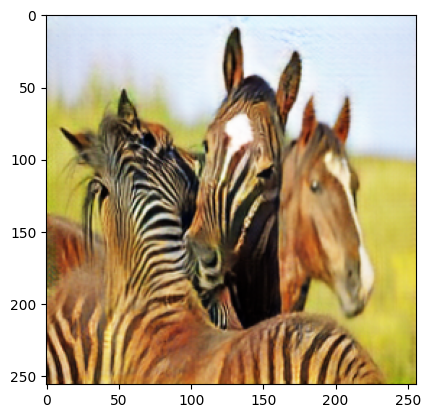

In [21]:
import matplotlib.pyplot as plt

img = plt.imread('./results/horse2zebra_pretrained/test_latest/images/n02381460_1010_fake.png')
plt.imshow(img)

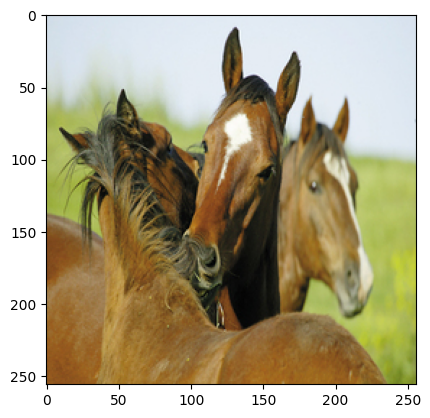

In [22]:
import matplotlib.pyplot as plt

img = plt.imread('./results/horse2zebra_pretrained/test_latest/images/n02381460_1010_real.png')
plt.imshow(img)

## Train

In [19]:
!python train.py \
    --dataroot ./datasets/horse2zebra \
    --name horse2zebra \
    --model cycle_gan \
    --display_id -1 \
    --n_epochs 1 --n_epochs_decay 1

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/horse2zebra        	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: -1                            	[default: 1]
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
 

# WESPE

In [3]:
from networks.wespe.main import (
    load_checkpoints, train, test,
    load_test_data, WESPE, config,
    SummaryWriter, predict
)

import torch
import os

In [4]:
config.train_iters = 2
config.print_step = 1
config.dataset_dir = './datasets/dped_small/'

device = torch.device('cuda:0' if config.use_cuda else 'cpu')
models = WESPE(config).to(device)
if config.load_iter != 0:
    load_checkpoints(models)

models.train()
writer = SummaryWriter(logdir=os.path.join(config.tensorboard_dir, config.phone))
train(models, writer, device)

models.eval()
test(models, device)

Iteration: 1/2, gen_loss: 0.3180, dis_loss: 2.7201
gen_loss_content: 0.2621, gen_loss_color: 0.8246, gen_loss_texture: 4.1288, gen_loss_tv: 0.0031
dis_loss_color: 1.3330, dis_loss_texture: 1.3871
Iteration: 2/2, gen_loss: 0.2772, dis_loss: 2.7678
gen_loss_content: 0.1864, gen_loss_color: 14.1986, gen_loss_texture: 0.0000, gen_loss_tv: 0.0020
dis_loss_color: 0.9348, dis_loss_texture: 1.8329
PSNR : 6.9288, SSIM_skimage : 0.0000, SSIM_minstar : 0.9737, SSIM_msssim: 0.9979


In [4]:
config.train_iters = 2
config.print_step = 1
config.dataset_dir = './datasets/dped_small/'
config.resume_iter = 20000

device = torch.device('cuda:0' if config.use_cuda else 'cpu')

models = WESPE(config).to(device)
load_checkpoints(models)
models.eval()
test(models, device)

Loading the model checkpoints from iter 20000...


/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


PSNR : 15.6135, SSIM_minstar : 0.9965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


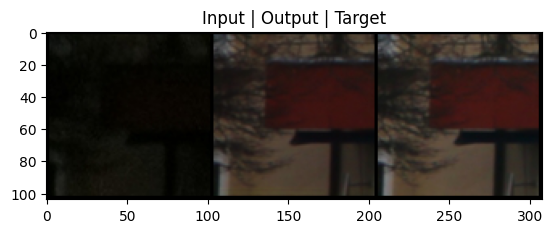

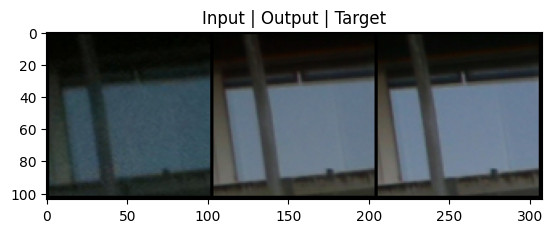

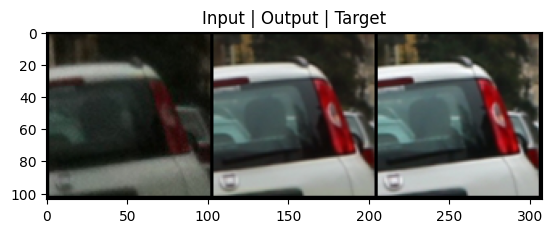

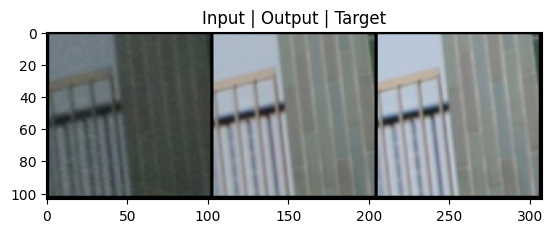

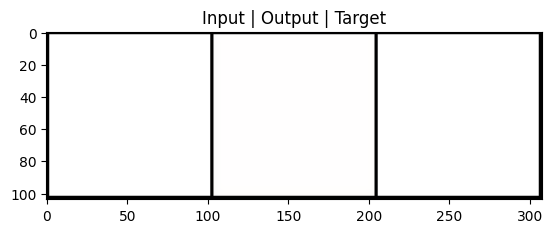

In [8]:
def predict_batch(model, device):
    test_path = config.dataset_dir + config.phone + '/test_data/patches/canon/'
    test_image_num = len([name for name in os.listdir(test_path)
                         if os.path.isfile(os.path.join(test_path, name))]) // config.batch_size * config.batch_size

    n = 0
    max_n = 5

    for start in range(0, test_image_num, config.batch_size):
        if n == max_n:
            break
        n += 1

        end = min(start + config.batch_size, test_image_num)
        test_phone, test_dslr = load_test_data(config.phone, config.dataset_dir, start, end,
                                               config.height * config.width * config.channels)
        prediction = predict(model, test_phone, test_dslr, device)

        plt_display(prediction, "Input | Output | Target")


predict_batch(models, device)

# UVCGAN v2

In [24]:
import os
os.chdir('../../networks/uvcgan2/')

In [26]:
!bash ./scripts/download_dataset.sh selfie2anime

--2024-02-05 12:33:01--  https://www.dropbox.com/s/9lz6gwwwyyxpdnn/selfie2anime.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/9lz6gwwwyyxpdnn/selfie2anime.zip [following]
--2024-02-05 12:33:01--  https://www.dropbox.com/s/raw/9lz6gwwwyyxpdnn/selfie2anime.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0edb1fde37e36fc8f699d518c5.dl.dropboxusercontent.com/cd/0/inline/CMtBrGaO7yYyc5kKDPoCU5SxQISsCeGzzE388w77y98kGB8GGQvHrTFjKyeOo-RuUN-unmbTiXGMamR_sVSNKS7iVrW7TC98I5qy0CgtUsL4riryuycJPii9bkl5jddBnOvh7z6Y1vJ0MQHELfdaDFL1/file# [following]
--2024-02-05 12:33:02--  https://uc0edb1fde37e36fc8f699d518c5.dl.dropboxusercontent.com/cd/0/inline/CMtBrGaO7yYyc5kKDPoCU5SxQISsCeGzzE388w77y98kGB8GGQvHrTFjKyeOo-RuUN-unmbTiXGMamR_sVSNKS7

In [29]:
!bash ./scripts/download_model.sh anime2selfie_anime2selfie

--2024-02-05 12:47:51--  https://zenodo.org/record/7826901/files/anime2selfie_anime2selfie_only_gen.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7826901/files/anime2selfie_anime2selfie_only_gen.zip [following]
--2024-02-05 12:47:52--  https://zenodo.org/records/7826901/files/anime2selfie_anime2selfie_only_gen.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 478016336 (456M) [application/octet-stream]
Saving to: ‘/home/gosha20777/Documents/Projects/uvcgan2/results//anime2selfie_anime2selfie_only_gen.zip’

/home/gosha20777/Do 100%[===================>] 455,87M  62,6MB/s    in 7,3s    

2024-02-05 12:47:59 (62,1 MB/s) - ‘/home/gosha20777/Documents/Projects/uvcgan2/results//anime2selfie_anime2selfie_only_gen.zip’ saved [478016336/47801

In [36]:
!python3 translate_images.py /home/gosha20777/Documents/Projects/uvcgan2/results/anime2selfie/anime2selfie --split test

/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Load checkpoint at epoch None
Translating domain 0:   0%|                             | 0/100 [00:00<?, ?it/s]/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Translating domain 1: 100%|███████████████████| 100/100 [00:04<00:00, 20.63it/s]


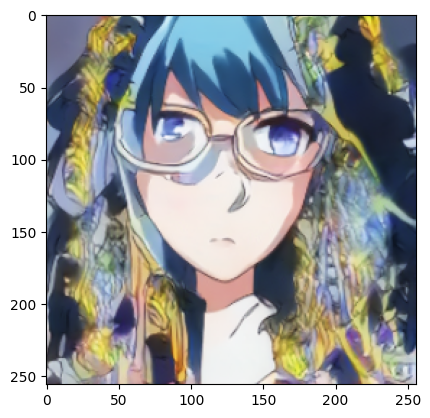

In [42]:
base_dir = "/home/gosha20777/Documents/Projects/uvcgan2/results/anime2selfie/anime2selfie/evals/final/images_eval-test"
fake = os.path.join(base_dir, "fake_b/sample_1.png")
real = os.path.join(base_dir, "real_a/sample_1.png")

import matplotlib.pyplot as plt

img = plt.imread(fake)
plt.imshow(img)

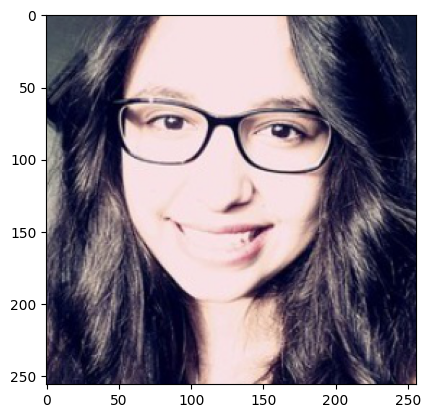

In [43]:
import matplotlib.pyplot as plt

img = plt.imread(real)
plt.imshow(img)